<font size =4> Import the Data

In [2]:
import pandas as pd       
import numpy as np   
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error                  
import os    
#load dataset 
df=pd.read_csv('E:/train.csv')

<font size =3> I decide to add some features based on existing features, which can enhance the model performance; The following functions can help me to calculate additional features based on original dataset.

In [4]:
def calculate_imbalance_features(df):
    df['imb_s1'] = (df['bid_size'] - df['ask_size']) / (df['bid_size'] + df['ask_size'])
    df['imb_s2'] = (df['imbalance_size'] - df['matched_size']) / (df['matched_size'] + df['imbalance_size'])
    return df

def calculate_price_distance(df):
    df['price_distance'] = abs(df['far_price'] - df['reference_price'])
    return df

def calculate_bid_ask_pressure(df):
    df['bid_ask_pressure'] = (df['bid_size'] * df['bid_price']) / (df['ask_price'] * df['ask_size'])
    return df

def calculate_wap_change(df):
    df['wap_change'] = df['wap'].diff()
    return df

def calculate_relative_strength_index(df, period=14):  
    delta = df['reference_price'].diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    gain_avg = up.rolling(window=period).mean()
    loss_avg = down.abs().rolling(window=period).mean()
    RS = gain_avg / loss_avg
    df['RSI'] = 100 - (100 / (1 + RS))
    return df

def generate_features(df):
    df = df.copy() 
    df = calculate_imbalance_features(df)
    df = calculate_price_distance(df)
    df = calculate_bid_ask_pressure(df)
    df = calculate_wap_change(df)
    df = calculate_relative_strength_index(df)

    # Selecting only the required features
    features = ['imbalance_size', 'matched_size', 'bid_size', 'ask_size',
                'reference_price', 'far_price', 'near_price', 'ask_price', 'bid_price', 'wap','imb_s1', 'imb_s2', 'price_distance', 'RSI', 'bid_ask_pressure', 'wap_change']
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)
    
    feature_df = df[features]

    return df, feature_df, features

<font size=3>The next is used for Cross-validation,and in thie function, I will employ the Expanding Window Method.

In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from math import sqrt

def MLpipe_KFold_RMSE(df, preprocessor, ML_algo, param_grid):
    '''
    This function uses an expanding window approach for time-series cross-validation.
    The initial training window is 150 days, expanding by 30 days for each subsequent split.
    For each split, the remaining 30 days data after the training window is used as the test set.
    It fits a model using GridSearchCV and calculates RMSE on the test set for each window.
    Finally, it returns a list of RMSE test scores and the corresponding best models.
    '''
    unique_dates = df['date_id'].unique()
    initial_train_size = 150
    expanding_size = 30
    total_splits = 11
    test_scores = []
    best_models = []

    # Iterate over the dataset creating expanding windows
    for split_num in range(total_splits):
        # Determine the training window for the current split
        train_end = initial_train_size + split_num * expanding_size
        
        # Ensure we don't go past the end of the dataset
        if train_end > len(unique_dates):
            break

        # Split the data into training and testing sets based on 'date_id'
        train_dates = unique_dates[:train_end]
        test_dates = unique_dates[train_end:]

        train_data = df[df['date_id'].isin(train_dates)]
        test_data = df[df['date_id'].isin(test_dates)]

        # Split data into features and target
        X_train, y_train = train_data.drop('target', axis=1), train_data['target']
        X_test, y_test = test_data.drop('target', axis=1), test_data['target']

        # Feature generation 
        preprocessed_X_train, X_train, features = generate_features(X_train)
        preprocessed_X_test, X_test, features = generate_features(X_test)

        # Create a machine learning pipeline
        pipe = make_pipeline(preprocessor, ML_algo())
        
        tsv = TimeSeriesSplit(n_splits=4)

        # Implement GridSearchCV for hyperparameter tuning on the training set
        grid = GridSearchCV(pipe, param_grid=param_grid, scoring='neg_mean_squared_error',
                            cv=tsv, return_train_score=False, n_jobs=-1, verbose=1)
        try:
            grid.fit(X_train, y_train)
        except ValueError as e:
            print(f"An error occurred during grid search: {e}")
            continue

        # Predict on the test set with the best model and calculate RMSE
        y_test_pred = grid.best_estimator_.predict(X_test)
        rmse = sqrt(mean_squared_error(y_test, y_test_pred))

        test_scores.append(rmse)
        best_models.append(grid.best_estimator_)

    return test_scores, best_models


<font size =5>Linear Regression (l1)

In [40]:
from sklearn.linear_model import Lasso
import inspect
alpha_Lasso=np.linspace(0.001,2,10)
param_grid={
    "lasso__Alpha":alpha_Lasso
}

test_scores_Lasso,best_models_Lasso=MLpipe_KFold_RMSE(df,preprocessor, Lasso, param_grid)
test_scores_Lasso

Fitting 4 folds for each of 10 candidates, totalling 40 fits
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[7.365760023036921,
 7.452077120472925,
 7.618532755405737,
 6.88508735068107,
 12.330093746643731,
 6.908081579273454,
 6.849614553431727,
 7.075169748181578,
 7.3780441889851,
 9.097176630554351,
 6.7404708683571]

<font size =5> RandomForestRegressor

In [43]:
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    #'randomforestregressor__n_estimators': [10,100,500],
    'randomforestregressor__max_depth': [10, 20, 30],
    'randomforestregressor__min_samples_split': [2, 5, 10],
    #'randomforestregressor__min_samples_leaf': [1, 2, 4],
    #'randomforestregressor__max_features': ['auto', 'sqrt', 'log2']
}

test_scores_RF, best_models_RF=MLpipe_KFold_RMSE(df, preprocessor, RandomForestRegressor, param_grid)
test_scores_RF

Fitting 4 folds for each of 9 candidates, totalling 36 fits
Fitting 4 folds for each of 9 candidates, totalling 36 fits
Fitting 4 folds for each of 9 candidates, totalling 36 fits
Fitting 4 folds for each of 9 candidates, totalling 36 fits
Fitting 4 folds for each of 9 candidates, totalling 36 fits
Fitting 4 folds for each of 9 candidates, totalling 36 fits
Fitting 4 folds for each of 9 candidates, totalling 36 fits
Fitting 4 folds for each of 9 candidates, totalling 36 fits
Fitting 4 folds for each of 9 candidates, totalling 36 fits
Fitting 4 folds for each of 9 candidates, totalling 36 fits
Fitting 4 folds for each of 9 candidates, totalling 36 fits


[8.15605910128735,
 7.557876963020759,
 7.665067914415534,
 6.999628535597667,
 7.347857134396333,
 7.074737547723172,
 6.975746824816626,
 7.412366786836755,
 7.602587730767185,
 9.192670289542777,
 7.062979680838336]

In [44]:
best_models_RF

[Pipeline(steps=[('columntransformer',
                  ColumnTransformer(transformers=[('std', StandardScaler(),
                                                   ['imbalance_size',
                                                    'matched_size', 'bid_size',
                                                    'ask_size',
                                                    'reference_price',
                                                    'far_price', 'near_price',
                                                    'ask_price', 'bid_price',
                                                    'wap', 'imb_s1', 'imb_s2',
                                                    'price_distance', 'RSI',
                                                    'bid_ask_pressure',
                                                    'wap_change'])])),
                 ('randomforestregressor', RandomForestRegressor(max_depth=10))]),
 Pipeline(steps=[('columntransformer',
                  Colu

<font size =5> Support Vector Regressor

In [45]:
from sklearn.svm import SVR 
import inspect
param_grid={
    "svr__gamma":[1e-3, 1e-1, 1e1,1e3],
    "svr__C": [1e-1, 1e0, 1e1]
}

test_scores_SVR, best_models_SVR=MLpipe_KFold_RMSE(df, preprocessor, SVR, param_grid)
test_scores_SVR

Fitting 4 folds for each of 12 candidates, totalling 48 fits
Fitting 4 folds for each of 12 candidates, totalling 48 fits
Fitting 4 folds for each of 12 candidates, totalling 48 fits
Fitting 4 folds for each of 12 candidates, totalling 48 fits
Fitting 4 folds for each of 12 candidates, totalling 48 fits
Fitting 4 folds for each of 12 candidates, totalling 48 fits
Fitting 4 folds for each of 12 candidates, totalling 48 fits
Fitting 4 folds for each of 12 candidates, totalling 48 fits
Fitting 4 folds for each of 12 candidates, totalling 48 fits
Fitting 4 folds for each of 12 candidates, totalling 48 fits
Fitting 4 folds for each of 12 candidates, totalling 48 fits


[7.3774164620127225,
 7.532658635744526,
 7.72101044761183,
 6.904938724037824,
 7.382617634840862,
 6.957981133693527,
 7.003357649626859,
 7.1407674252677324,
 7.401099672211256,
 9.176900117534661,
 6.788157793631847]

<font size =5>KNeighborsRegressor

In [47]:
from sklearn.neighbors import KNeighborsRegressor

param_grid = {
    "kneighborsregressor__n_neighbors": [1,5,10,50,100,500]
}


test_scores_KNR, best_models_KNR=MLpipe_KFold_RMSE(df, preprocessor, KNeighborsRegressor, param_grid)
test_scores_KNR

Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits


[7.388806983226135,
 7.56512464862579,
 7.725956475047414,
 6.9955152273152015,
 7.4179618595937695,
 6.951720994353038,
 6.979219563842428,
 7.139435464907038,
 7.4663018928783655,
 9.258466306007994,
 6.783026508389041]

<font size =5>XGBoost Regressor

In [50]:
from xgboost import XGBRegressor

param_grid = {
    #'xgbregressor__n_estimators': [300,500],  # Number of gradient boosted trees. Equivalent to number of boosting rounds.
    'xgbregressor__learning_rate': [0.01,0.1],  # Step size shrinkage used to prevent overfitting. Range is [0,1]
    'xgbregressor__max_depth': [3, 8,20,40],  # Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.
    #'xgbregressor__min_child_weight': [1, 5, 10],  # Minimum sum of instance weight (hessian) needed in a child.
    #'xgbregressor__subsample': [0.5, 0.7, 1.0],  # Subsample ratio of the training instances.
    #'xgbregressor__colsample_bytree': [0.5, 0.7, 1.0],  # Subsample ratio of columns when constructing each tree.
    #'xgbregressor__gamma': [0, 0.1, 0.5],  # Minimum loss reduction required to make a further partition on a leaf node of the tree.
    #'xgbregressor__reg_alpha': [0, 0.1, 1],  # L1 regularization term on weights. Increasing this value will make model more conservative.
    #'xgbregressor__reg_lambda': [1, 0.1, 0.01],  # L2 regularization term on weights. Increasing this value will make model more conservative.
}

test_scores_XGBR, best_models_KNR=MLpipe_KFold_RMSE(df, preprocessor, XGBRegressor, param_grid)
test_scores_XGBR

Fitting 4 folds for each of 8 candidates, totalling 32 fits
Fitting 4 folds for each of 8 candidates, totalling 32 fits
Fitting 4 folds for each of 8 candidates, totalling 32 fits
Fitting 4 folds for each of 8 candidates, totalling 32 fits
Fitting 4 folds for each of 8 candidates, totalling 32 fits
Fitting 4 folds for each of 8 candidates, totalling 32 fits
Fitting 4 folds for each of 8 candidates, totalling 32 fits
Fitting 4 folds for each of 8 candidates, totalling 32 fits
Fitting 4 folds for each of 8 candidates, totalling 32 fits
Fitting 4 folds for each of 8 candidates, totalling 32 fits
Fitting 4 folds for each of 8 candidates, totalling 32 fits


[7.366558487550916,
 7.569486114300335,
 7.734548029838388,
 6.994594058527725,
 7.364771076178691,
 6.969821964985307,
 7.000884181882468,
 7.242714971496973,
 7.476599547149296,
 9.229119261841078,
 6.78211877583747]

<font size=4>Calculate the baseline accuracy, which is RMSE for this regressin problem.I simply use the mean value of target variable as the predictions, and calculate the difference between those mean values and true values.

In [64]:
import numpy as np
from sklearn.metrics import mean_squared_error


mean_target_value = np.mean(df['target'])

# Create an array of predictions where each prediction is the mean target value
baseline_predictions = np.full_like(df['target'], fill_value=mean_target_value, dtype=float)

# Calculate the baseline RMSE
baseline_rmse = np.sqrt(mean_squared_error(df['target'], baseline_predictions))

print(f"Baseline RMSE is: {baseline_rmse}")


Baseline RMSE is: 9.636138148306785


<font size =4> Now I just need to plot a figure which shows each model's mean and standard deviation.

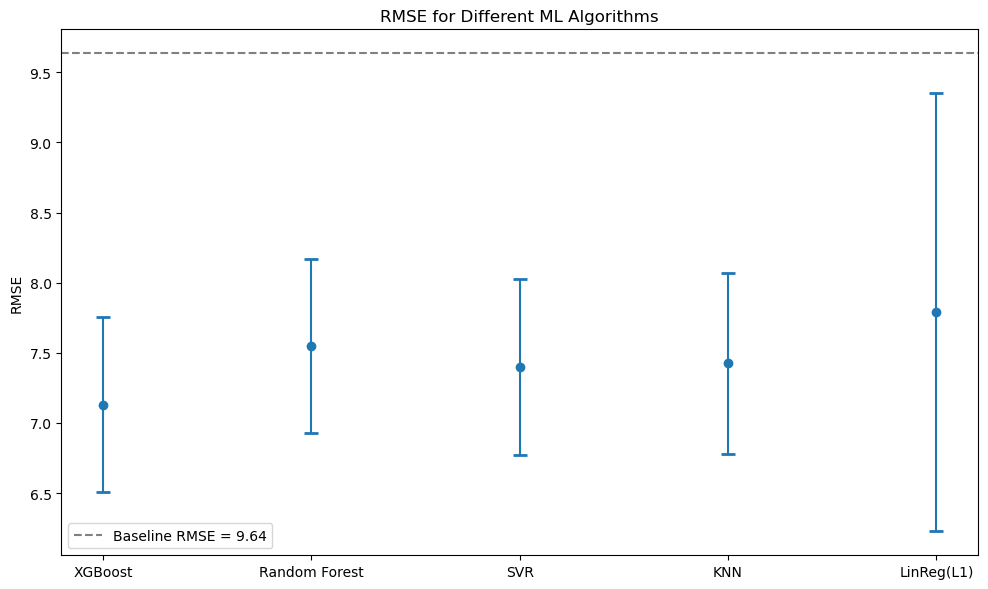

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.errorbar(models, means, yerr=stds, fmt='o', capsize=5, capthick=2)
plt.axhline(y=baseline_rmse, color='Gray', linestyle='--', label=f'Baseline RMSE = {baseline_rmse:.2f}')
plt.title('RMSE for Different ML Algorithms')
plt.ylabel('RMSE')
#plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig('E:/RMSE for different Algorithms_1.png', dpi=450)
plt.show()

<font size=4>Print Out the means and stds for each model

In [7]:
means,stds

([7.130110588144422,
  7.549779864476591,
  7.398809608746695,
  7.424685084016929,
  7.7909189604566995],
 [0.6224408217966103,
  0.6206509932454666,
  0.6265462143647303,
  0.6449608930841737,
  1.564024476618576])

<font size=4>The best model is XGBoostRegressor. The next part we will discuss the Global Feature Importance.

In [9]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

#We don't need those unimportant features, so we don't select them
df_train = df.query('date_id <478')
h=[c for c in df.columns if c not in ['stock_id','date_id','time_id','row_id','target']]
X_train= df_train[h]
y_train= df_train['target']
processed_train_df, X_train,features = generate_features(X_train)


h=[c for c in df.columns if c not in ['stock_id','date_id','time_id','row_id','target']]
X_CV= df_1[h]
y_CV= df_1['target']
processed_test_df, X_CV,features = generate_features(X_CV)
std_ftrs = features
preprocessor = ColumnTransformer(
    transformers=[
        ('std', StandardScaler(), std_ftrs)])
preprocessor.fit(X_train,y_train)

In [10]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import ParameterGrid
from xgboost import XGBRegressor
import xgboost
param_grid = {"learning_rate": [0.01],
              "n_estimators": [1000],
              "colsample_bytree": [0.9],              
              "subsample": [0.66]}

XGB = xgboost.XGBRegressor(early_stopping_rounds=50)
XGB.set_params(**ParameterGrid(param_grid)[0])
XGB.fit(X_train,y_train,eval_set=[(X_CV, y_CV)],verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<font size =5>Global Feature Importance - Permutation Importance

In [11]:
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor
import xgboost
df_1=df.query('date_id>=478')
h=[c for c in df.columns if c not in ['stock_id','date_id','time_id','row_id','target']]
X_test= df_1[h]
y_test= df_1['target']
processed_test_df, X_test,features = generate_features(X_test)
# Calculate permutation feature importance
perm_importance = permutation_importance(XGB, X_test, y_test, n_repeats=10, random_state=1030, n_jobs=-1)

# Sort the importance and select the top 10 most important ones index
sorted_idx = perm_importance.importances_mean.argsort()
top_10_idx = sorted_idx[-10:]  

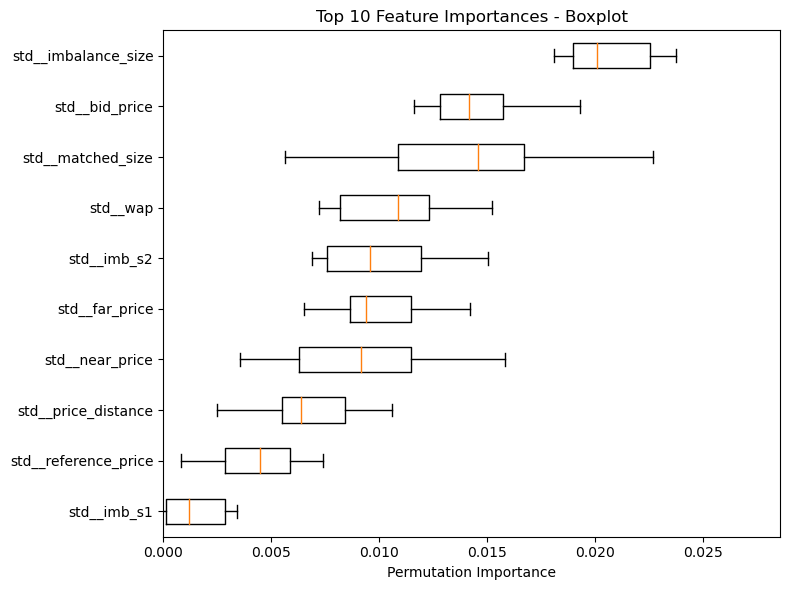

In [16]:
import matplotlib.pyplot as plt
import numpy as np
test_score = XGB.score(X_test,y_test)
top_10_scores = [perm_importance.importances[i] for i in top_10_idx]
ftr_names = preprocessor.get_feature_names_out()
plt.figure(figsize=(8, 6))
plt.boxplot(top_10_scores, vert=False, labels=np.array(ftr_names)[top_10_idx], showfliers=False)
plt.xlabel('Permutation Importance')
plt.title('Top 10 Feature Importances - Boxplot')
plt.tight_layout()
plt.show()

<font size = 5>Global Feature Importance=Total_Gain

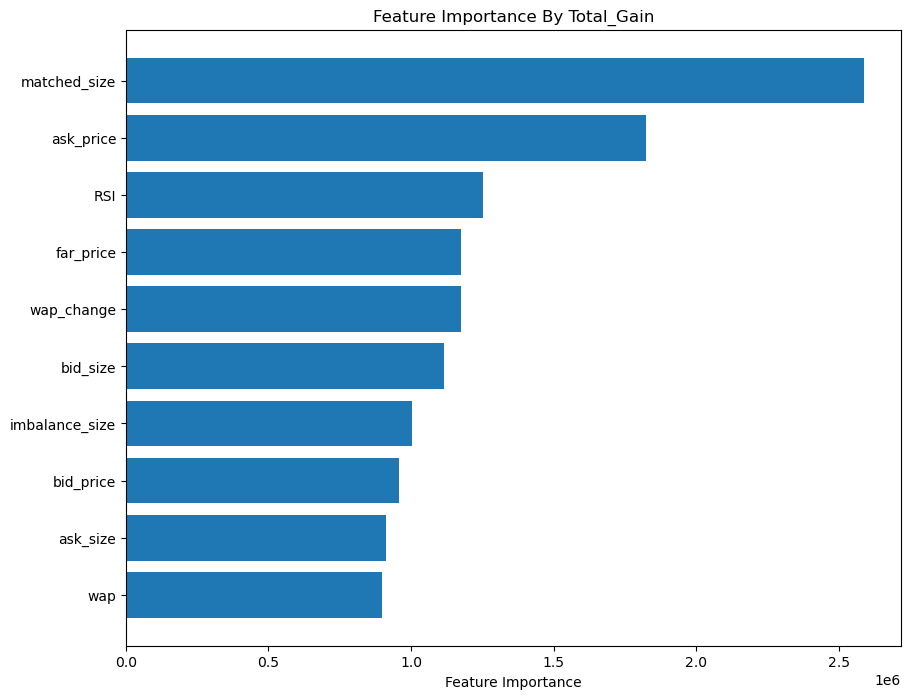

In [17]:
# Get feature importances
importance_dict = XGB.get_booster().get_score(importance_type='total_gain')
# Sort features by importance
sorted_features = sorted(importance_dict, key=importance_dict.get, reverse=True)
# Take the top 10 features
top_features = sorted_features[:10]
top_importances = [importance_dict[i] for i in top_features]

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(range(10), top_importances[::-1])
plt.yticks(range(10), top_features[::-1])
plt.xlabel('Feature Importance')
plt.title('Feature Importance By Total_Gain')
plt.show()

<font size=5>Global Feature Importance=Weight

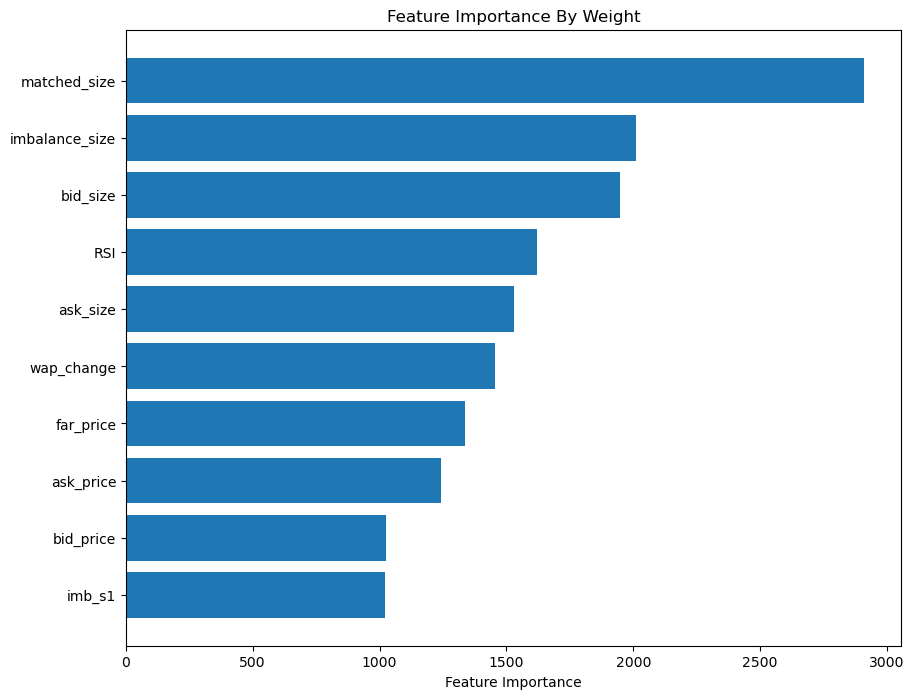

In [19]:
##Weight
# Get feature importances
importance_dict = XGB.get_booster().get_score(importance_type='weight')
# Sort features by importance
sorted_features = sorted(importance_dict, key=importance_dict.get, reverse=True)
# Take the top 10 features
top_features = sorted_features[:10]
top_importances = [importance_dict[i] for i in top_features]

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(range(10), top_importances[::-1])
plt.yticks(range(10), top_features[::-1])
plt.xlabel('Feature Importance')
plt.title('Feature Importance By Weight')
plt.show()


<font size=5>Global Feature Importance - Shap value

[22:12:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[22:12:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


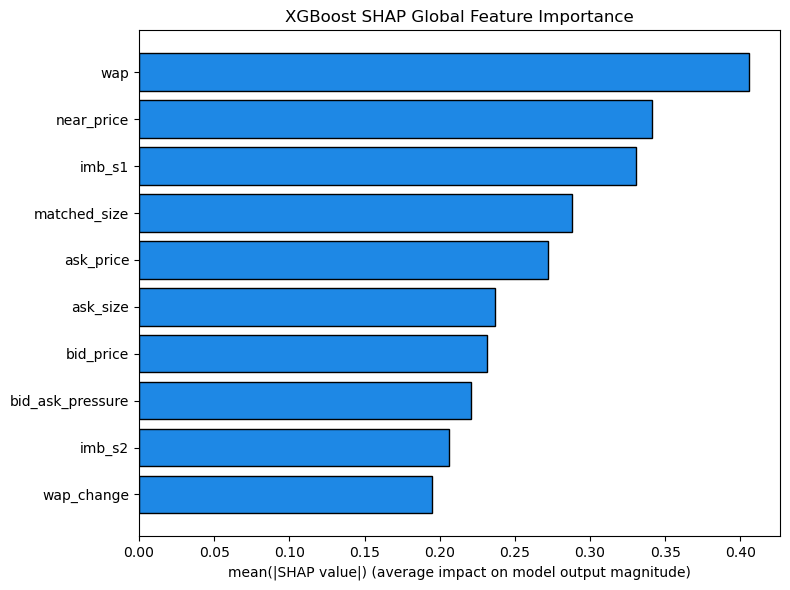

In [25]:
import shap
XGB.save_model("model.json")
explainer = shap.Explainer(XGB)
shap_values = explainer.shap_values(X_test)
shap_summary = np.abs(shap_values).mean(0)
indcs = np.argsort(shap_summary)
top_10_idx = indcs[-10:]

# Get feature names
feature_names = X_test.columns[top_10_idx]

plt.figure(figsize=(8, 6))
bar_colors = ['#1E88E5'] * len(top_10_idx)  # Replace with color of your choice
edge_color = ['#000000'] * len(top_10_idx)  # Replace with color of your choice
plt.barh(range(len(top_10_idx)), shap_summary[top_10_idx], color=bar_colors, edgecolor=edge_color)
plt.yticks(range(len(top_10_idx)), feature_names)
plt.xlabel('mean(|SHAP value|) (average impact on model output magnitude)')
plt.title('XGBoost SHAP Global Feature Importance')
plt.savefig('E:/SHAP', dpi=450)
plt.tight_layout()
plt.show()



<font size=5>SHAP values for local feature importance

In [36]:
# your code here
shap.initjs()
index = 100 # the index of the point to that I want to explain
print(explainer.expected_value) # The expected Value is close to the mean value in the y_test
feature_names=X_test.columns
shap.force_plot(explainer.expected_value, shap_values[index,:], features = X_test.iloc[index,:],feature_names = feature_names)

-0.021361828


In [37]:
# your code here
shap.initjs()
index = 1000 # the index of the point to that I want to explain
print(explainer.expected_value) # The expected Value is close to the mean value in the y_test
feature_names=X_test.columns
shap.force_plot(explainer.expected_value, shap_values[index,:], features = X_test.iloc[index,:],feature_names = feature_names)

-0.021361828


In [38]:
# your code here
shap.initjs()
index = 3864 # the index of the point to that I want to explain
print(explainer.expected_value) # The expected Value is close to the mean value in the y_test
feature_names=X_test.columns
shap.force_plot(explainer.expected_value, shap_values[index,:], features = X_test.iloc[index,:],feature_names = feature_names)

-0.021361828
